In [1]:
%matplotlib inline
import torch, random
from d2l import torch as d2l

# 一、生成数据集

> 为了简单起见，我们将根据带有噪声的线性模型构造一个人造数据集。 我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。

使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$和噪声项 $\epsilon$ 生成数据集及其标签
$$
\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.
$$

In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w))) # 元组是张量规模
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape) # 添加噪声项
    return X, y.reshape((-1, 1)) # 返回一个二维张量作为X, 一个一维张量作为值y

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

然后可以将得到的数据可视化

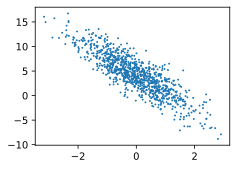

In [3]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

# 二、读取数据集

首先定义一个函数从给定数据集中获取小批量数据

In [4]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) # 打乱顺序
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)]) # 获取batch_size个索引
        yield features[batch_indices], labels[batch_indices] # 一次产生batch_size个批量数据

可以利用GPU并行运算的特点，同时对多个大小合适的小批量进行处理。

进行数据读取：

In [5]:
batch_size = 10
for batch_X, batch_y in data_iter(batch_size, features, labels):
    print(batch_X, '\n', batch_y)
    break

tensor([[-1.6581, -0.6640],
        [-0.3417, -0.5644],
        [-1.7515, -1.1349],
        [-0.5866, -0.2327],
        [ 0.7416, -0.6135],
        [ 1.0003, -0.0576],
        [ 0.5751, -1.5384],
        [-0.1429,  0.1756],
        [-0.3142,  1.9566],
        [-0.3633,  2.4026]]) 
 tensor([[ 3.1496],
        [ 5.4410],
        [ 4.5533],
        [ 3.8160],
        [ 7.7730],
        [ 6.4062],
        [10.5802],
        [ 3.3277],
        [-3.0790],
        [-4.7053]])


# 三、初始化模型参数

In [6]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# 如果初始化为0，则模型将会失效

# 四、定义模型

In [7]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

# 五、定义损失函数

In [8]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

# 六、定义优化算法

使用小批量随机梯度下降法

In [9]:
# @torch.no_grad()
def sgd(params, lr, batch_size): #@save # 传入params是一个引用，使得可以修改外部的值
    with torch.no_grad(): # 在这个语句块中将不会考虑梯度，可以节省空间，等价于对函数使用@torch.no_grad()修饰器
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

其中`params`为待处理的参数（此处为$\mathbf{w}$和$b$），`lr`为学习率$\eta$，`batch_size`为每次处理的数量

# 七、训练

做好准备后，可以开始训练了。大致过程如下：
1. 初始化参数
2. 重复以下过程，直到完成
    1. 计算梯度$\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    2. 更新参数$(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In [10]:
lr = 0.03
num_epochs = 3 # 指定超参数
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print("epoch ", epoch + 1, ", loss ", float(train_l.mean()), sep="")

epoch 1, loss 0.03211057186126709
epoch 2, loss 0.00011119191185571253
epoch 3, loss 4.934281969326548e-05


现在可以查看训练出的参数和原始参数的区别，以衡量训练是否成功

In [11]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0002, -0.0008], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0009], grad_fn=<RsubBackward1>)


通过改变超参数（此处为`lr`和`num_epochs`）调整训练效果的过程称为**调参**。并非训练次数越多越好，也并非学习率越高越好，需要不断调整来找到较好的超参数。即使对于同一组超参数，不同的训练中得到的效果一般也不相同